# 2020-12-21

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/fbc767f27eea9fe708c35a7688d02fec34dcf79d 
(Rerunning the code below for other commits is not guaranteed to give the same results)

Following up on the previous (Dec 11 and 13) diary entries with a rerun of the same simulations, after having introduced use of `sc_scenario_helper.get_time_to_sc_agent_collision()` to calculate the time to collision, based on the conflict space concept (currently assuming quadratic agents of equal size) rather than euclidean collision distance (effectively assuming circular agents of equal size). 

Also some minor improvements to the behaviour acceleration calculations have been made.

In [1]:
# put root folder of repo PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))
print(sys.path[-1])

C:\GITHUB\COMMOTIONSFramework


In [2]:
# imports needed to run the simulations
import numpy as np
import commotions
from sc_scenario import get_assumptions_dict, SCSimulation
from sc_scenario_helper import CtrlType

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:17: UserWarning: Currently removing target_dist > 0 requirement from get_acc_to_be_at_dist_at_time - needed because of current slight incompatibility between definitions of collision course.
  warnings.warn('Currently removing target_dist > 0 requirement from '
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:78: UserWarning: N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.
  warnings.warn('N_ACTIONS set to no of actions in default params, so will not work if non-default params are set.')


Text from prev entries: 
* Dec 11: *First running a pedestrian crossing scenario with just the base assumptions, for an initial situation such that this just barely has the car passing first. (Increasing the car's initial X position to 45 m makes the pedestrian slide in front.)*
* Dec 13: *Getting back exactly the same results here, as we should.*

No longer self-evident that we would get back the same results, since the definition of TTC has changed slightly, but we do.

C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:162: UserWarning: ****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.
  warnings.warn('****** Setting initial value of i_CONSTANT behaviour activation to arbitrary high value.')
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:877: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_PLOTROWS, 1, 1)
C:\GITHUB\COMMOTIONSFramework\sc_scenario.py:883: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, b

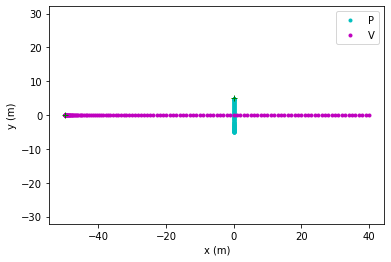

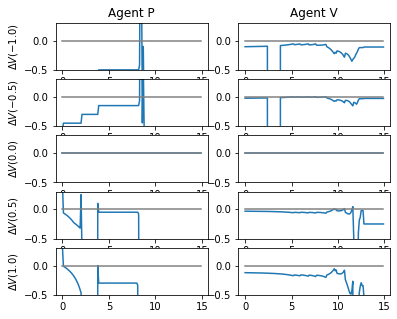

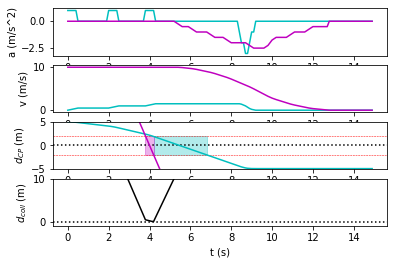

In [3]:
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [40, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 10))

optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        trajs = True, kinem_states = True, surplus_action_vals = True)

Text from prev entries:
* Dec 11: *Now turning on value based behaviour estimation (`oBEvs` here). This causes the interaction to break down quite a bit, with lots of oscillations in both agents' behaviour. But we can see in the $P_{b|a}$ plots that the vehicle is estimating the acceleration should increase the probability of the pedestrian yielding - but the vehicle still does not do it.*
* Dec 12: *We get back either the same behaviour or something very similar. We can see slight differences in the estimated expected accelerations, but at least so far they are quite similar to the previous calculations.*

The outcome changes now, due to the new TTC calculation. Things actually look a little bit more sensible now than previously, in the sense that the vehicle yielding is now followed by the pedestrian passing first. Difficult to draw any conclusions from this though.

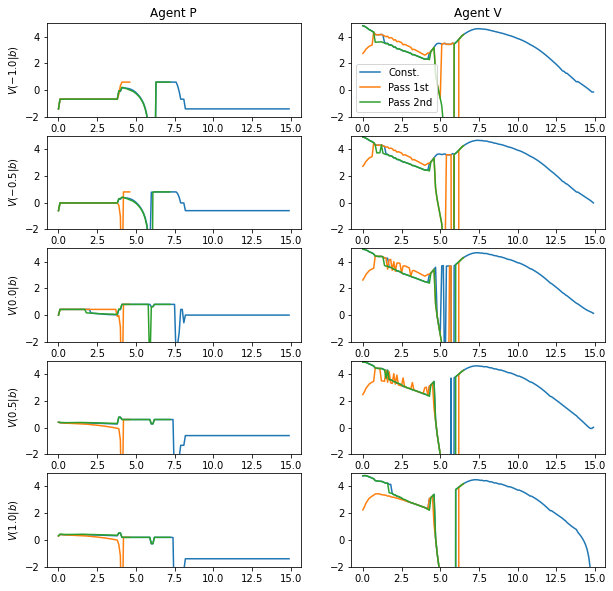

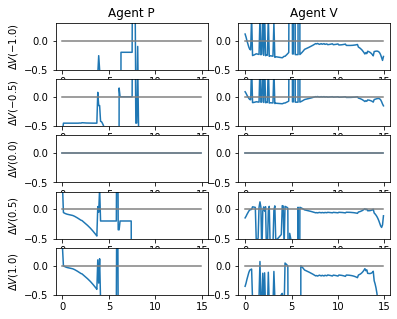

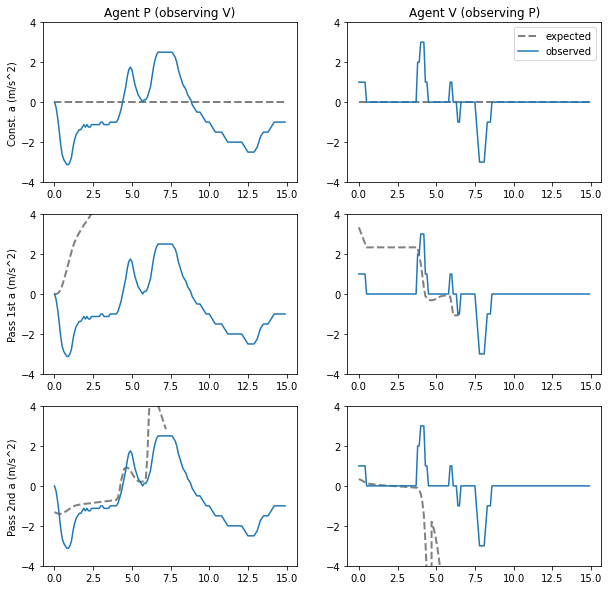

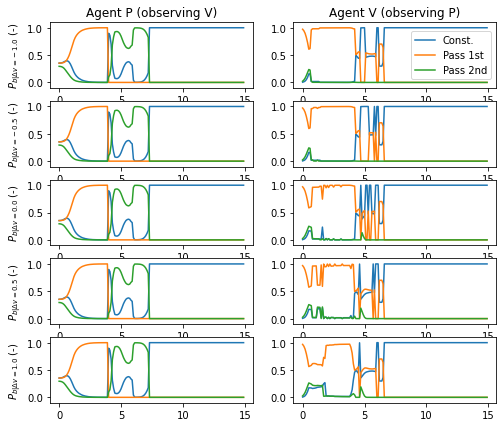

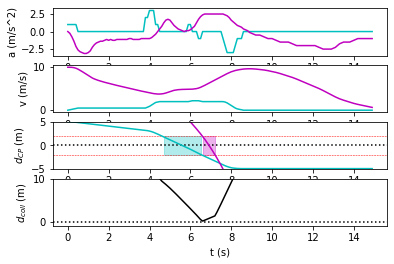

In [4]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entries:
* Dec 11: *Now turning on also evidence accumulation. This stabilises things - but now the vehicle no longer thinks that accelerating could affect the pedestrian's behaviour - I am not sure why.*
* Dec 13: *Here the differences in expected accelerations become more obvious, and now the added evidence accumulation is enough to just barely have the vehicle refrain from the deceleration that happened in the simulation just above - so in a sense this is a "better", more sensible-looking outcome.*

Here, we get the same behaviour as Dec 13 - the evidence accumulation just barely prevents the vehicle from yielding.

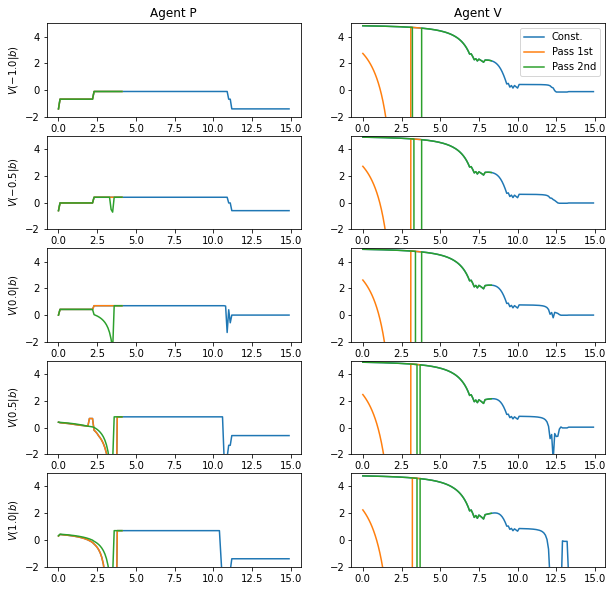

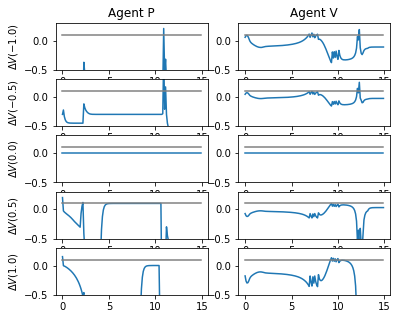

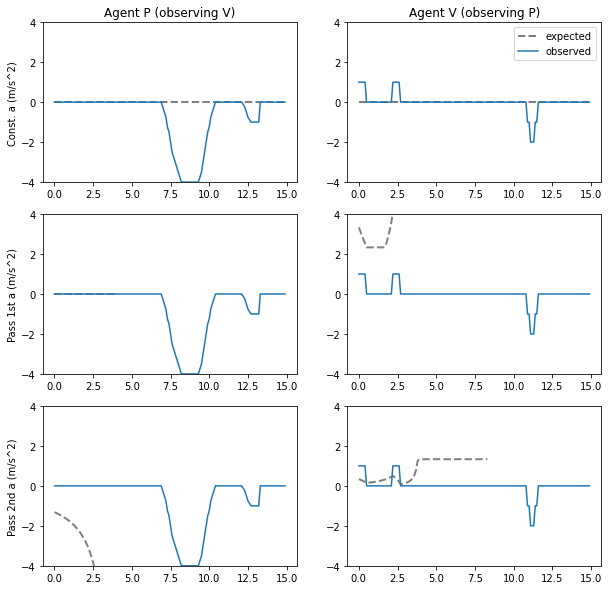

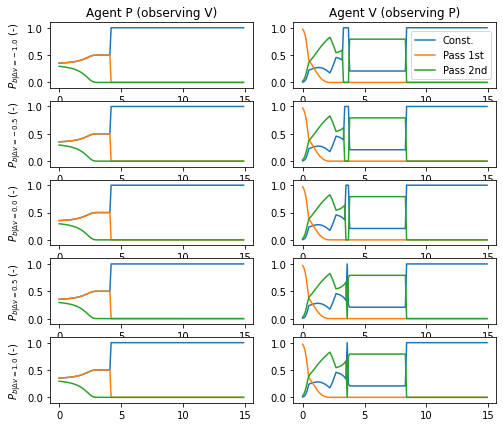

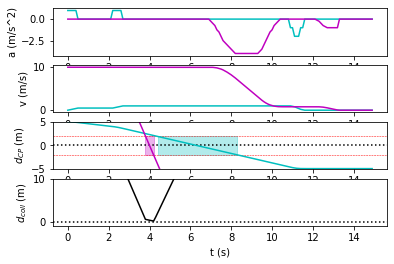

In [5]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = False, oBEvs = True, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entries:
* Dec 11: *Now turning off value based behaviour estimation and evidence accumulation, and instead turning on action observation based behaviour estimation (`oBEao`). Again this causes a lot of oscillation and a poor interaction.*
* Dec 13: *This looks like a case where the new calculations added noticeable improvement. Now the vehicle understands that the pedestrian can be walking slowly forward in order to pass behind the vehicle, so it is less likely to interpret the pedestrian as trying to push in front.*

Again very similar results to Dec 13.

We can also note that the vehicle driver's expectation for the pedestrian's acceleration in order to pass 2nd from t = 4 s now looks more sensible than in the Dec 13 simulations - this is the mentioned improvement / bug fix to the behaviour acceleration calculations. However, there are still some spikes in the expected accelerations just as agents are about to enter the conflict space - they shouldn't really affect model behaviour much, but a bit annoyoing that I can't figure out where they come from...

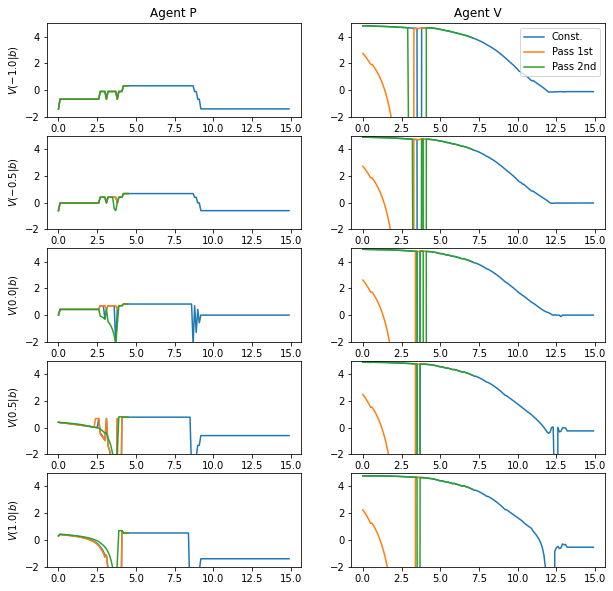

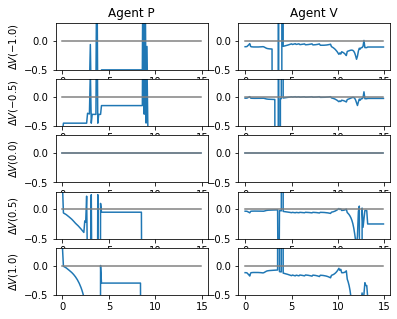

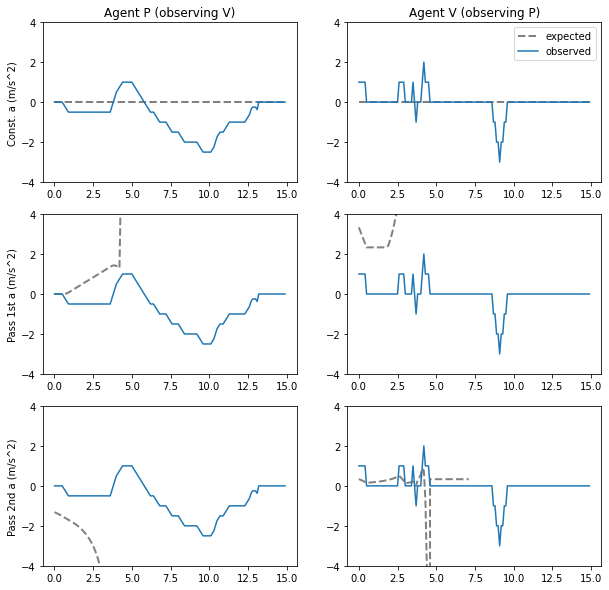

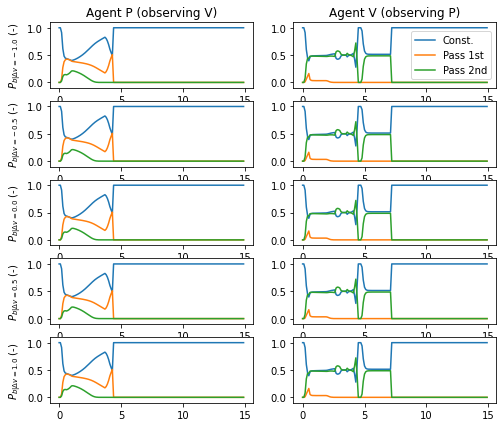

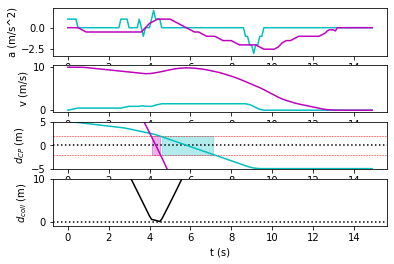

In [6]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = False, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entries:
* Dec 11: *Adding evidence accumulation into the mix here dampens things a bit, but not much.*
* Dec 13: *And just like with `oBEvs`, adding in the evidence accumulation, we get back nice behaviour.*

Similarly to Dec 13, adding the evidence accumulation prevents the initial yielding. But here, there is also another change: the vehicle speeds up at t = 3.8 s or so, just as it is entering the conflict space. This is seemingly because it realises that the pedestrian can now begin accelerating a bit more towards its free speed, to pass smoothly behind the vehicle (the increasing expected acc for ped to pass 2nd), but somehow this now looks to the driver as if it will cause a collision (the downward spike in V(0|P pass 2nd). So there is still some mismatch between the TTC calculations and the behavioural acceleration calculations...

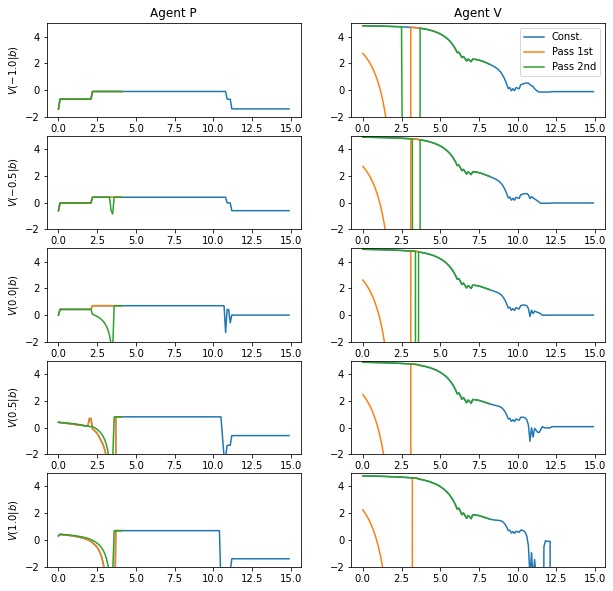

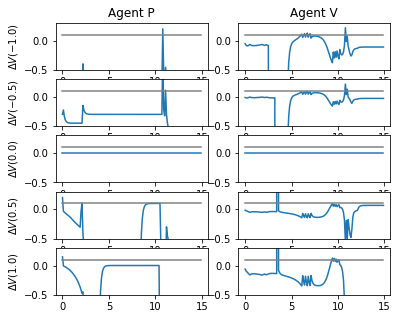

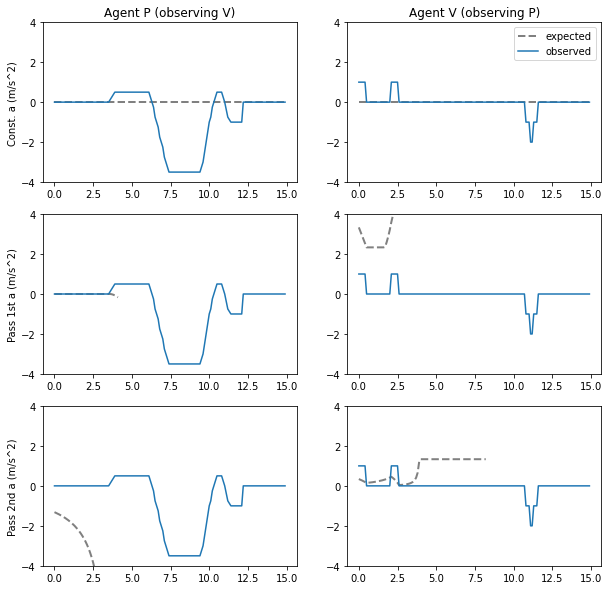

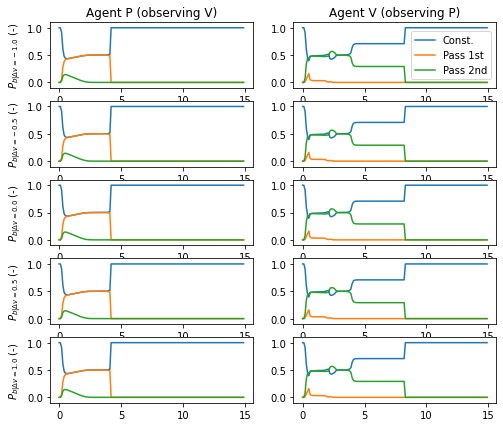

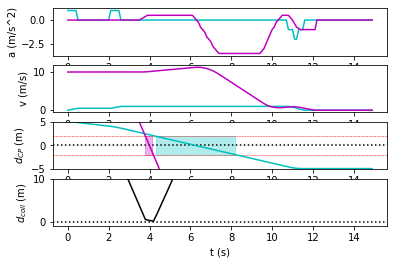

In [7]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = False, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entries: 
* Dec 11: *Now, interestingly, turning on both value based and action observation based behaviour estimation improves the interaction quite considerably.*
* Dec 13: *And now, combining both action observation based and value based action observation, we now get back the nice original behaviour, even without evidence accumulation.*

Same now as Dec 13.

There is still the big downward spike in V(0|P pass 2nd) for the vehicle around t = 3.8 s, but interestingly this now does not cause the car to speed up, because the inclusion of `oBEvs` makes the car driver estimate that the pedestrian isn't likely to engage in a behaviour that will cause a collision. Still a bit iffy that the TTC / beh acc calculations don't completely align though...

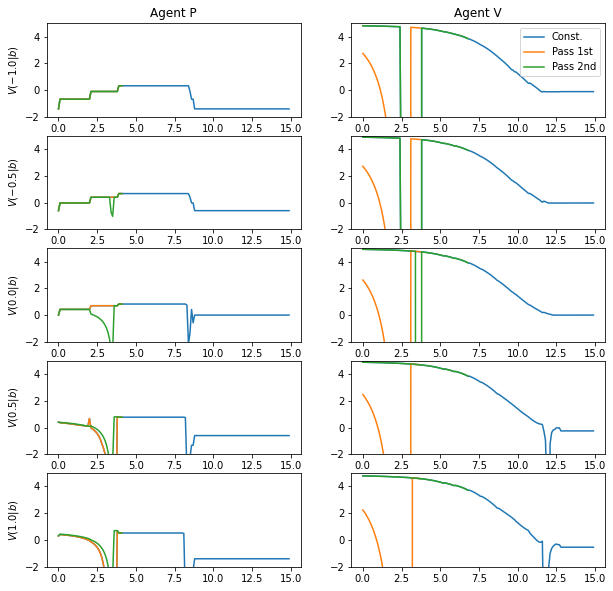

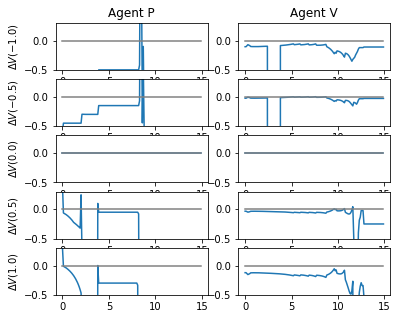

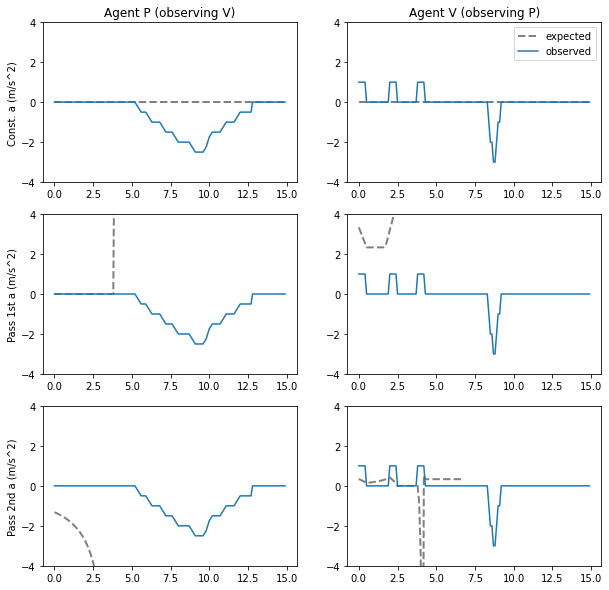

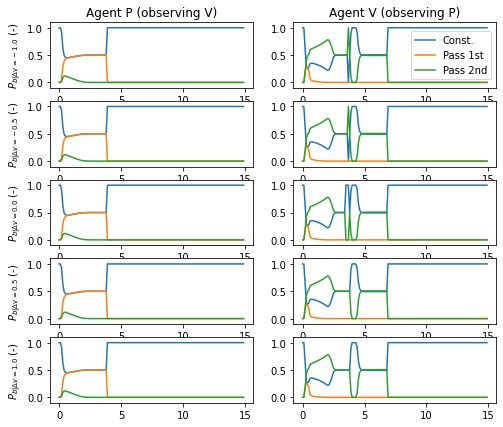

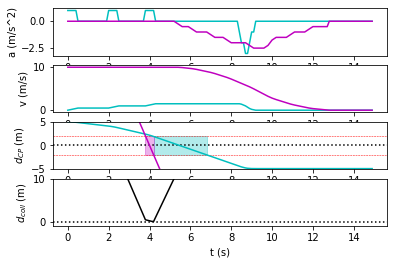

In [8]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = True, oEA = False)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entres:
* Dec 11: *And turning on also evidence accumulation essentially brings us back to the original smooth behaviour of just the base framework.*
* Dec 13: *Since we were already sort of back to the original in the previous simulation above, nothing much further happens here.*

Same as Dec 13.

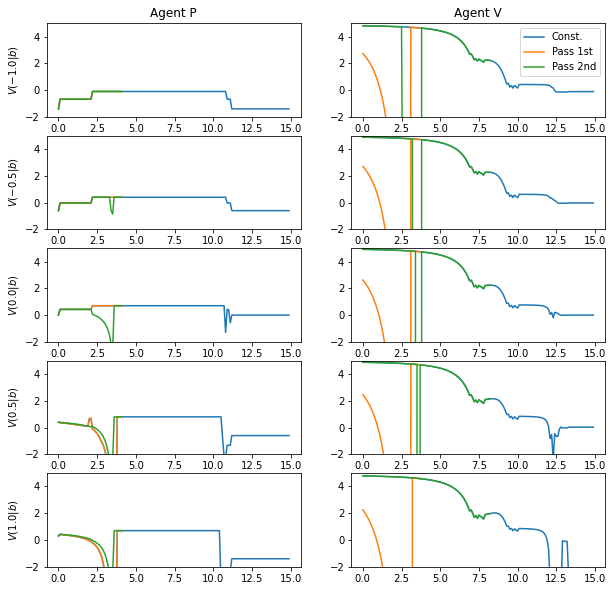

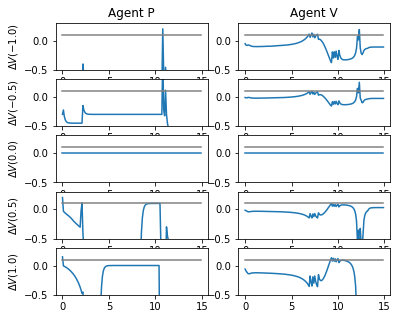

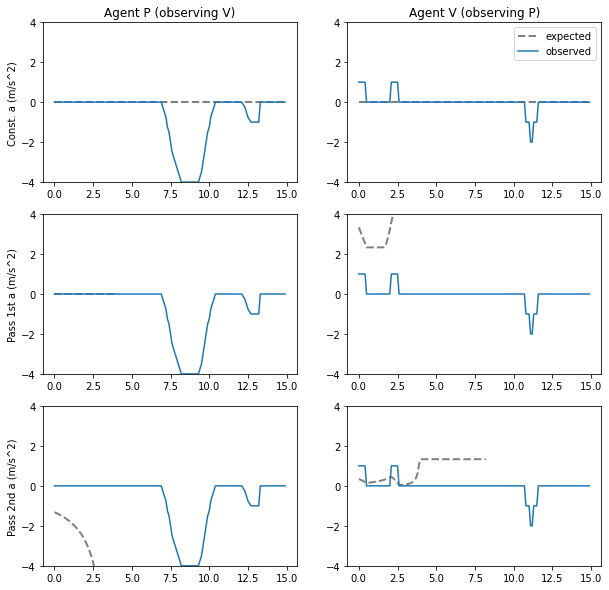

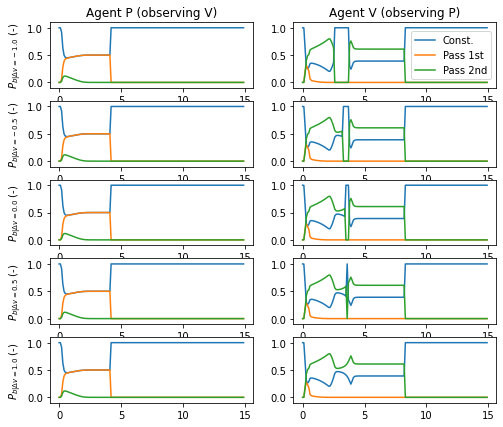

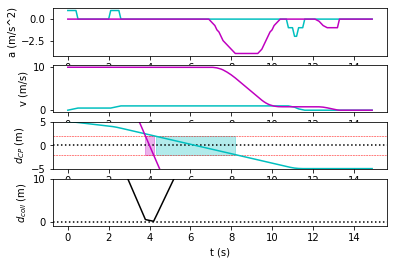

In [10]:
optional_assumptions = get_assumptions_dict(
        default_value = False, oBEao = True, oBEvs = True, oEA = True)  
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

Text from prev entries:
* Dec 11: *And really interestingly, now slightly increasing the initial TTA of the vehicle, causes a situation where the vehicle performs what looks like a rather smooth and nice yielding to the pedestrian - from being a bit uncertain about what the pedestrian is up to. And it takes the pedestrian a few seconds to decide that it looks safe to cross in front of the vehicle- It's a quite natural-looking interaction I think.*
* Dec 13: *This remains nice-looking here.*

With the new TTC calculation I had to increase initial TTA a bit further (from 45 m to 47 m initial vehicle position) to get vehicle yielding behaviour. 

The other notable feature of this simulation is that the vehicle stays at a low speed after yielding. This is a consequence of the current decision-making dynamics - which have the limitation of not being good at making decisions that are just marginally better than doing nothing. 

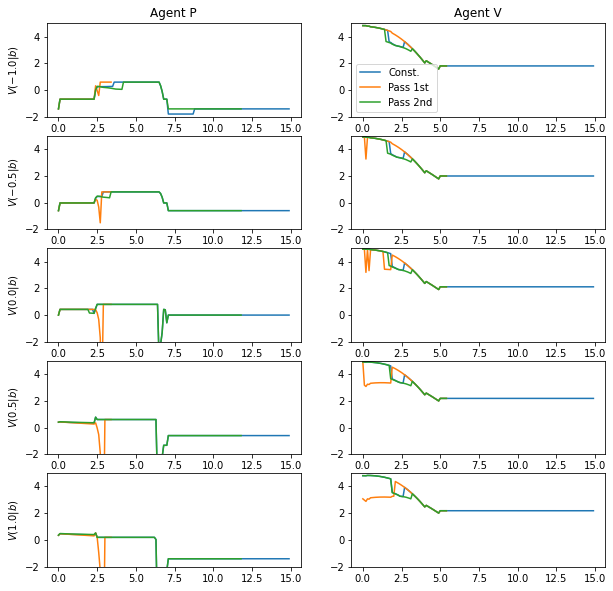

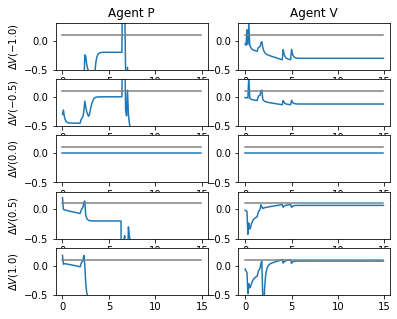

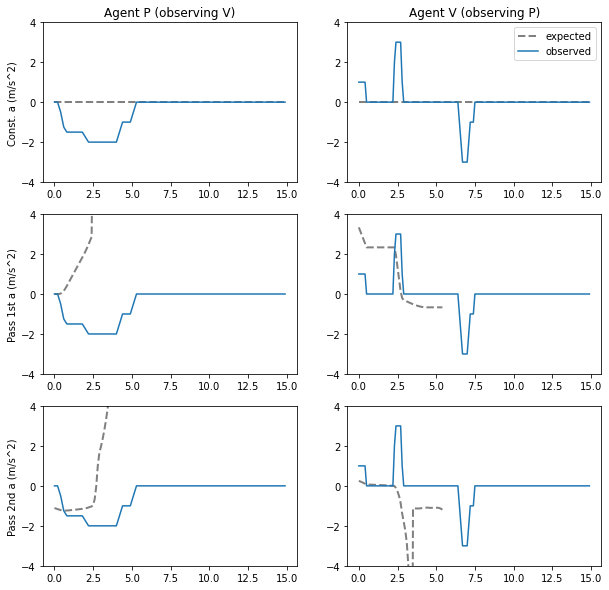

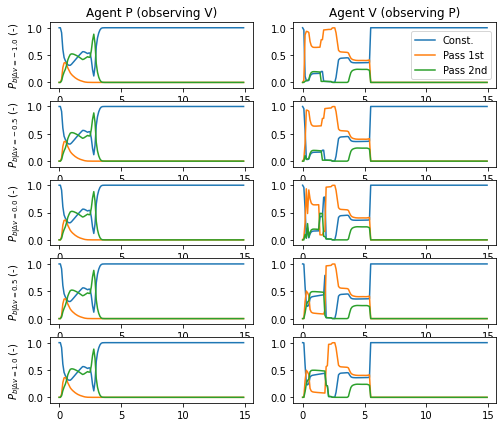

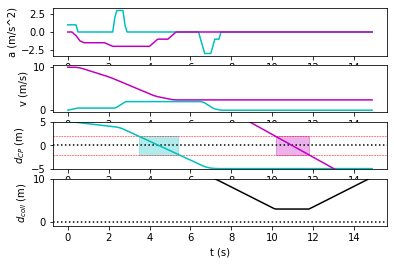

In [12]:
INITIAL_POSITIONS = np.array([[0,-5], [47, 0]])
sc_simulation = SCSimulation(
        CTRL_TYPES, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = ('P', 'V'))
sc_simulation.run()
sc_simulation.do_plots(
        kinem_states = True, beh_probs = True, beh_accs = True, surplus_action_vals = True, action_vals = True)

No new overall notes beyond those of Dec 11/13.